In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw""
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using DataFrames

function expand_grid(; iters...)
    var_names = collect(keys(iters))
    var_itr = [1:length(x) for x in iters.data]
    var_ix = vcat([collect(x)' for x in Iterators.product(var_itr...)]...)
    out = DataFrame()
    for i = 1:length(var_names)
        out[:,var_names[i]] = collect(iters[i])[var_ix[:,i]]
    end
    return out
end

d = expand_grid(iteration=1:3, Possibilities=["a", "b","c", "d"], stage = ["a", "b"])

d2 =DataFrame(Credibility =[fill(.25,4); 0; fill(1/3,3); 0; fill(1/3,3);0;.5;0;0.5;0;.5;0;0.5;fill(0,3);1])

sort!(d, [:iteration])
d.Credibility = d2.Credibility

┌ Warning: use values(kwargs) and keys(kwargs) instead of kwargs.data and kwargs.itr
│   caller = expand_grid(; iters::Base.Pairs{Symbol, AbstractVector, Tuple{Symbol, Symbol, Symbol}, NamedTuple{(:iteration, :Possibilities, :stage), Tuple{UnitRange{Int64}, Vector{String}, Vector{String}}}}) at In[2]:5
└ @ Main ./In[2]:5


24-element Vector{Float64}:
 0.25
 0.25
 0.25
 0.25
 0.0
 0.3333333333333333
 0.3333333333333333
 0.3333333333333333
 0.0
 0.3333333333333333
 0.3333333333333333
 0.3333333333333333
 0.0
 0.5
 0.0
 0.5
 0.0
 0.5
 0.0
 0.5
 0.0
 0.0
 0.0
 1.0

In [3]:
first(d,5)

,iteration,Possibilities,stage,Credibility
,Int64,String,String,Float64
1,1,a,a,0.25
2,1,b,a,0.25
3,1,c,a,0.25
4,1,d,a,0.25
5,1,a,b,0.0


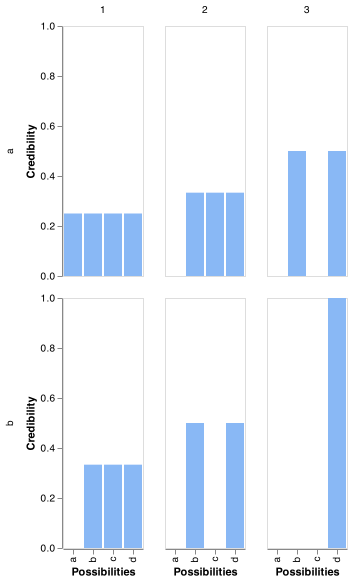

WARN column encoding should be discrete (ordinal / nominal / binned).
WARN column encoding should be discrete (ordinal / nominal / binned).


In [4]:
using Plots
using VegaLite

#bar(d.Possibilities, d.Credibility, layout = 6)

d |>
@vlplot(
  :bar,
  color=:green,
  column = {"iteration",axis={title=""}},
  row = {"stage:o", sort = "-stage", axis={title=""}},
  x={"Possibilities:n", title="Possibilities"},
  color={"Possibilities:n", scale={range=["#89b8f5"]}, axis={title=""}, legend = ""},
  y={"Credibility", axis={title="Credibility", grid=false}},
  height = 250)